In [657]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [658]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

# Goal

Calculate ci metrics for each release and output a dataset with one entry for release and a list of metrics as features

In [659]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.Date = pd.to_datetime(tags.Date)
tags.head(2)

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7


### Import builds and jobs

In [660]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)
builds.head(2)

,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,6995,NaN,99118995,push,2015-12-28 16:34:08+00:00,NaN,2015-12-28 16:18:41+00:00,5361.0,failed,28.0,12.0,2015.0
1,6994,NaN,99100662,push,2015-12-28 14:36:03+00:00,NaN,2015-12-28 14:18:30+00:00,5953.0,passed,28.0,12.0,2015.0


In [661]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs.shape

(136983, 13)

### Import tag comparison pairs

In [662]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
tags_comparison = tags_comparison[2:]
tags_comparison[["from_tag", "to_tag"]]

,from_tag,to_tag
2,5.1.1,5.1.2
3,5.1.2,5.2
4,5.2,5.3
5,5.3,5.4
6,5.4,5.5
7,5.5,5.6
8,5.6,5.6.1
9,5.6.1,5.6.2
10,5.6.1,6.0
11,5.6.2,5.6.3


## Import release commits

In [663]:
def replace_tags_with_jira(df):
    df = df.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")\
    .drop(columns=["to_tag", "Tag"]).rename(columns={"jira_version":"to_tag"})
    df = df.merge(tags[["Tag","jira_version"]], left_on="from_tag", right_on="Tag")\
    .drop(columns=["from_tag", "Tag"]).rename(columns={"jira_version":"from_tag"})
    return df

### Import tags difference commits (git log tag1...tag2) (1)

In [664]:
tags_comparison_commits = pd.read_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones.csv", index_col=0)
tags_comparison_commits.tail(2)

,from_tag,to_tag,ahead_sha
15603,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df
15604,8.4.1.35646,8.4.2.36762,fd2cb0c84d052b9ea773503be71a3bb3cda13cd6


In [665]:
tags_comparison_commits  = replace_tags_with_jira(tags_comparison_commits)
tags_comparison_commits.rename(columns={"ahead_sha": "commitsha"}, inplace=True)
tags_comparison_commits.tail(2)

,commitsha,to_tag,from_tag
15603,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,8.4.2,8.4.1
15604,fd2cb0c84d052b9ea773503be71a3bb3cda13cd6,8.4.2,8.4.1


In [666]:
tags_comparison_commits.shape

(15605, 3)

### Import tags commits (1) + iterative PRs

In [667]:
tags_iterative_pr_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_pairs_iterative_commits.csv", index_col=0)
tags_iterative_pr_commits.tail(2)

,from_tag,to_tag,commitsha
122451,8.4.1.35646,8.4.2.36762,ed1a72601c559e86ccd96004c99157421b6bcb20
122452,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df


In [668]:
tags_iterative_pr_commits  = replace_tags_with_jira(tags_iterative_pr_commits)
tags_iterative_pr_commits.tail(2)

,commitsha,to_tag,from_tag
122451,ed1a72601c559e86ccd96004c99157421b6bcb20,8.4.2,8.4.1
122452,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,8.4.2,8.4.1


In [669]:
tags_iterative_pr_commits.shape

(122453, 3)

### Import tags commits the ones nor in (1) or (2) assigned using Jira FixVersion for the issue in commitmessage

In [670]:
tags_fix_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_fix_commits.csv", index_col=0)
tags_fix_commits.tail(2)

,from_tag,to_tag,commitsha
3245,8.4,8.4.1,34a0bc1a4e14e13a7d40a410b268d6ea7b0f3a40
3246,8.4.1,8.4.2,df64c184d1427f74592459b42093e8b0b6878c98


In [671]:
tags_fix_commits.shape

(3247, 3)

# Start

In [672]:
def get_builds_from_commits(_commits):
    _build_ids = jobs[jobs.commitsha.isin(_commits)].buildid
    return builds[(builds.id.isin(_build_ids))]

def get_builds_from_ids(_builds, _build_ids):
    return _builds[(_builds.id.isin(_build_ids))]

def get_commits_from_comparison_row(row, commitsDf):
    _x = commitsDf
    return _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha

### Builds metrics

**Percentage of builds per state**

In [673]:
def calculate_percentage_state_builds(row, commitsDf, state=[]):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _all_builds = get_builds_from_commits(_commits)
    _builds = _all_builds[(_all_builds.state.isin(state))]
    return len(_builds)/len(_all_builds)

def calculate_percentage_state_builds_pr(row, state):
    return calculate_percentage_state_builds(row, tags_iterative_pr_commits, state)
def calculate_percentage_state_builds_direct(row, state):
    return calculate_percentage_state_builds(row, tags_comparison_commits, state)
def calculate_percentage_state_builds_fix(row, state):
    return calculate_percentage_state_builds(row, tags_fix_commits, state)
def calculate_percentage_state_builds_pr_and_fix(row, state):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_state_builds(row, _tmp, state)

In [745]:
for state in ["passed", "canceled", "failed", "errored"]:
    tags_comparison[f"ratio_{state}_builds"] = \
    tags_comparison.apply(calculate_percentage_state_builds_pr_and_fix, args=([state],), axis=1)

<Figure size 1008x360 with 0 Axes>

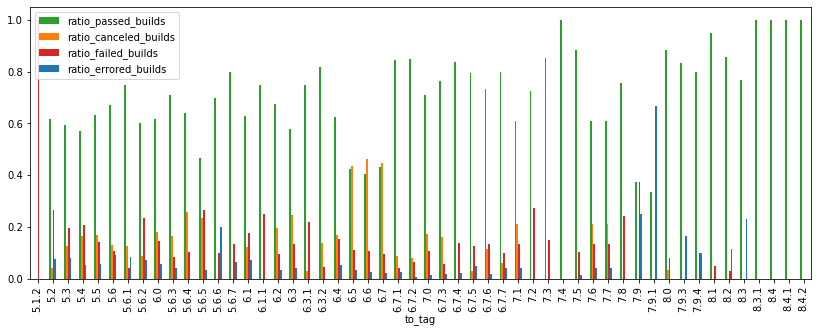

In [751]:
plt.figure()
cols = []
for state in ["passed", "canceled", "failed", "errored"]:
    cols.append(f"ratio_{state}_builds")
tags_comparison.set_index("to_tag")[cols].plot(kind="bar", color=["tab:green","tab:orange", "tab:red", "tab:blue"])
plt.savefig(f"{figure_folder}/ci-metrics/percentage_state_builds.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Number of builds per pull request**

In [676]:
def calculate_percentage_pr_builds(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _all_builds = get_builds_from_commits(_commits)
    _builds = _all_builds[(_all_builds.event_type == "pull_request")]
    return len(_builds)/len(_all_builds)

def calculate_percentage_pr_builds_pr(row):
    return calculate_percentage_pr_builds(row, tags_iterative_pr_commits)
def calculate_percentage_pr_builds_direct(row):
    return calculate_percentage_pr_builds(row, tags_comparison_commits)
def calculate_percentage_pr_builds_fix(row):
    return calculate_percentage_pr_builds(row, tags_fix_commits)
def calculate_percentage_pr_builds_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_pr_builds(row, _tmp)

In [677]:
tags_comparison["percentage_pr_builds"] = tags_comparison.apply(calculate_percentage_pr_builds_pr_and_fix, axis=1)

<AxesSubplot:>

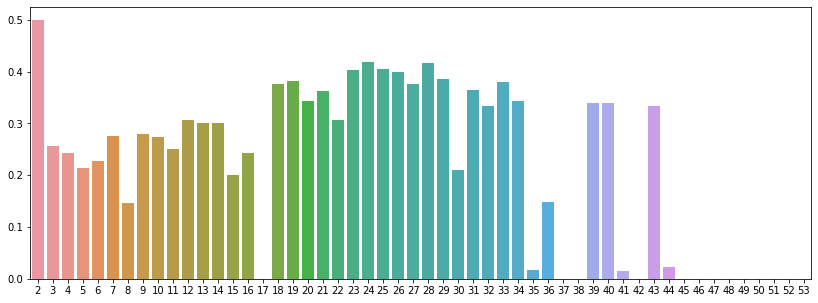

In [678]:
sns.barplot(x=tags_comparison["percentage_pr_builds"].index, \
            y=tags_comparison["percentage_pr_builds"].values)

In [679]:
tags_comparison[tags_comparison.percentage_pr_builds == 0.4]

,from_author_date,to_author_date,ahead_by,behind_by,from_sha,to_sha,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days,to_tag,from_tag,percentage_passed_builds,percentage_canceled_builds,percentage_failed_builds,percentage_errored_builds,percentage_pr_builds
26,2017-11-07 15:03:37,2017-12-20 16:32:02,25,0,5d031d9d2ac3f69b4b9bc600d50563b1886c7d8b,426519346f51f7b980a76f9050f983110550509d,25,43 days 01:28:25,43.0614,2017-11-07 16:03:37,2017-12-20 17:32:02,43 days 01:28:25,43.0614,6.7.1,6.7,0.843478,0.086957,0.043478,0.026087,0.4


In [680]:
tags_comparison[tags_comparison.percentage_pr_builds == 0][["from_tag", "to_tag"]]

,from_tag,to_tag
17,6.1,6.1.1
37,7.3,7.4
38,7.4,7.5
42,7.8,7.9
45,7.9.1,7.9.3
46,7.9.3,7.9.4
47,8.0,8.1
48,8.1,8.2
49,8.2,8.3
50,8.3,8.3.1


* 0% pull request builds may indicate mostly bug fixing done directly on the version branch. 
Indeed all the pairs with 0% do not represent major version upgrades

**Build duration for passed builds**

In [681]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_aggregator_build_duration(row, commitsDf, aggregator, state=None):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _all_builds = get_builds_from_commits(_commits)
    if(not state):
        _series = _all_builds.duration
    else:
        _series = _all_builds[_all_builds.state==state].duration
    res = getattr(_series, aggregator)()
    return res

def calculate_aggregator_build_duration_pr(row, aggregator, state):
    return calculate_aggregator_build_duration(row, tags_iterative_pr_commits, aggregator, state)
def calculate_aggregator_build_duration_direct(row, aggregator, state):
    return calculate_aggregator_build_duration(row, tags_comparison_commits, aggregator, state)
def calculate_aggregator_build_duration_fix(row, aggregator, state):
    return calculate_aggregator_build_duration(row, tags_fix_commits, aggregator, state)
def calculate_aggregator_build_duration_pr_and_fix(row, aggregator, state):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_aggregator_build_duration(row, _tmp, aggregator, state)
def calculate_aggregator_passed_build_duration_pr_and_fix(row, aggregator, state):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_aggregator_build_duration(row, _tmp, aggregator, state)

In [682]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_passed_build_duration"] =\
    tags_comparison.apply(calculate_aggregator_build_duration_pr_and_fix,\
                          args=(agg,"passed"), axis=1)

<AxesSubplot:>

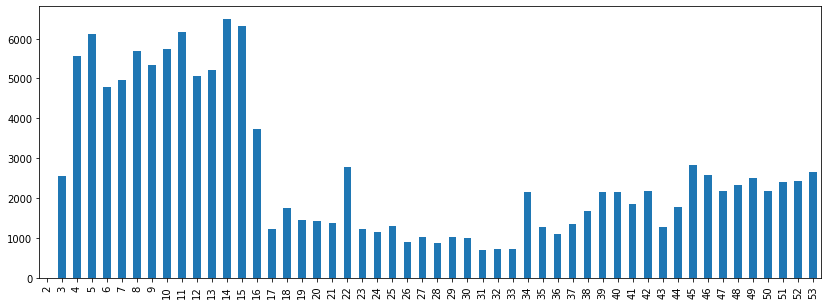

In [683]:
tags_comparison.mean_passed_build_duration.plot(kind="bar")

**Number of builds per pull request**

In [684]:
### Mean or median of number of jobs per pull request
def calculate_aggregator_n_builds_per_pull_request(row, commitsDf, aggregator):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.commitref.str.contains("refs/pull/")]
    _series = _jobs.groupby("commitref").buildid.nunique()
    res = getattr(_series, aggregator)()
    return res if not np.isnan(res) else 0
    
def calculate_aggregator_n_builds_per_pull_request_per_commit_pr(row, aggregator):
    return calculate_median_n_builds_per_pull_request(row, tags_iterative_pr_commits, aggregator)
def calculate_aggregator_n_builds_per_pull_request_per_commit_direct(row, aggregator):
    return calculate_median_n_builds_per_pull_request(row, tags_comparison_commits, aggregator)
def calculate_aggregator_n_builds_per_pull_request_per_commit_fix(row, aggregator):
    return calculate_median_n_builds_per_pull_request(row, tags_fix_commits, aggregator)
def calculate_aggregator_n_builds_per_pull_request_per_commit_pr_and_fix(row, aggregator):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_aggregator_n_builds_per_pull_request(row, _tmp, aggregator)

In [685]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_n_builds_per_pull_request"] =\
    tags_comparison.apply(calculate_aggregator_n_builds_per_pull_request_per_commit_pr_and_fix,\
                          args=(agg,), axis=1)

<AxesSubplot:>

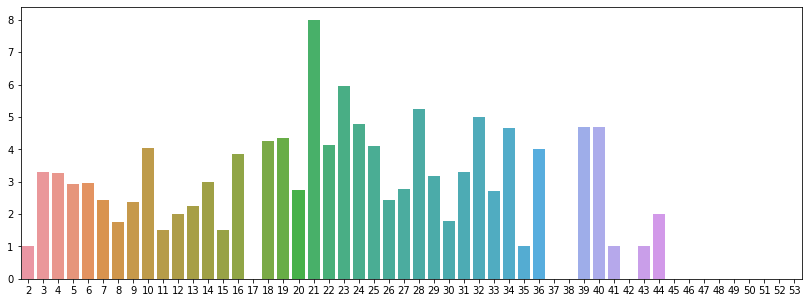

In [686]:
sns.barplot(x=tags_comparison["mean_n_builds_per_pull_request"].index, \
            y=tags_comparison["mean_n_builds_per_pull_request"].values)

<AxesSubplot:>

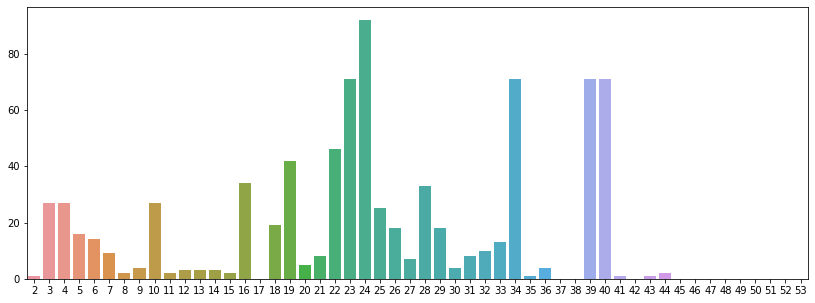

In [687]:
sns.barplot(x=tags_comparison.max_n_builds_per_pull_request.index, \
            y=tags_comparison.max_n_builds_per_pull_request.values)

**Number of builds per commitmessage**

In [688]:
### number of builds per pull request
def calculate_aggregator_n_builds_per_commitmessage(row, commitsDf, aggregator):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    _series = _jobs.groupby("commitmessage").buildid.nunique()
    res = getattr(_series, aggregator)()
    return res if not np.isnan(res) else 0
    
def calculate_aggregator_n_builds_per_commitmessage_per_commit_pr(row, aggregator):
    return calculate_aggregator_n_builds_per_commitmessage(row, tags_iterative_pr_commits, aggregator)
def calculate_aggregator_n_builds_per_commitmessage_per_commit_direct(row, aggregator):
    return calculate_aggregator_n_builds_per_commitmessage(row, tags_comparison_commits, aggregator)
def calculate_aggregator_n_builds_per_commitmessage_per_commit_fix(row, aggregator):
    return calculate_aggregator_n_builds_per_commitmessage(row, tags_fix_commits, aggregator)
def calculate_aggregator_n_builds_per_commitmessage_per_commit_pr_and_fix(row, aggregator):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_aggregator_n_builds_per_commitmessage(row, _tmp, aggregator)

In [689]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_n_builds_per_commitmessage"] =\
    tags_comparison.apply(calculate_aggregator_n_builds_per_commitmessage_per_commit_pr_and_fix,\
                          args=(agg,), axis=1)

<AxesSubplot:>

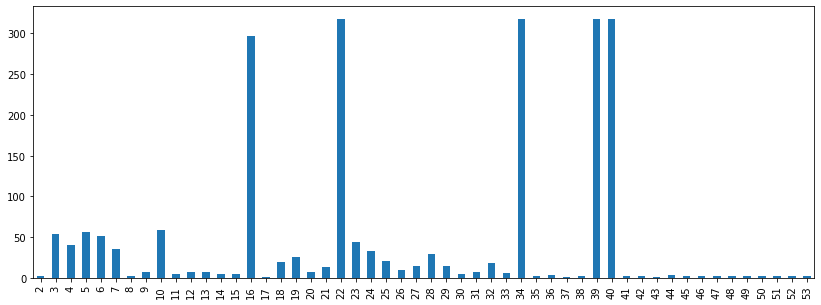

In [690]:
tags_comparison.max_n_builds_per_commitmessage.plot(kind="bar")

<AxesSubplot:>

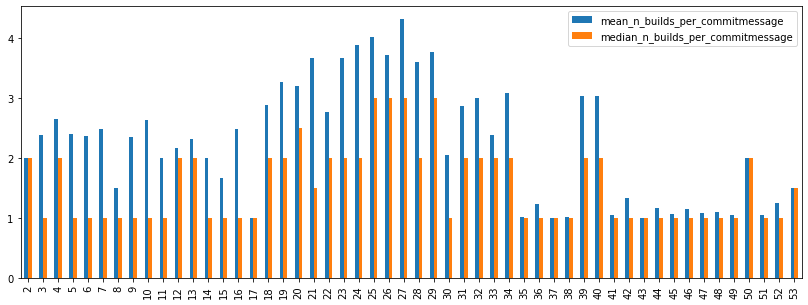

In [691]:
tags_comparison[["mean_n_builds_per_commitmessage", "median_n_builds_per_commitmessage"]].plot(kind="bar")

### Jobs metrics

**Average job duration**

jobs["duration"] = (jobs.finished_at - jobs.started_at) / np.timedelta64(1, "s")

### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_job_duration(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    return _jobs.duration.mean()

def calculate_average_job_duration_pr(row):
    return calculate_average_job_duration(row, tags_iterative_pr_commits)
def calculate_average_job_duration_direct(row):
    return calculate_average_job_duration(row, tags_comparison_commits)
def calculate_average_job_duration_fix(row):
    return calculate_average_job_duration(row, tags_fix_commits)

tags_comparison["mean_job_duration_builds_passed_or_failed"] = tags_comparison.apply(calculate_average_job_duration_pr, axis=1)

**Average failed jobs per commit**

### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_failed_job_per_commit(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    _jobs = _jobs[_jobs.state == "failed"]
    return _jobs.groupby("commitsha").state.count().mean()

def calculate_average_failed_job_per_commit_pr(row):
    return calculate_average_failed_job_per_commit(row, tags_iterative_pr_commits)
def calculate_average_failed_job_per_commit_direct(row):
    return calculate_average_failed_job_per_commit(row, tags_comparison_commits)
def calculate_average_failed_job_per_commit_fix(row):
    return calculate_average_failed_job_per_commit(row, tags_fix_commits)
def calculate_average_failed_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_failed_job_per_commit(row, _tmp)

tags_comparison["average_failed_job_per_commit"] = tags_comparison.apply(calculate_average_failed_job_per_commit_pr, axis=1)

sns.barplot(x=tags_comparison["average_failed_job_per_commit"].index, \
            y=tags_comparison["average_failed_job_per_commit"].values)

**Number of jobs canceled or errored**

### Mean or median of duration for jobs not from canceled or errored builds
def calculate_percentage_canceled_or_errored_job(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return len(_jobs[_jobs.state.isin(["canceled", "errored"])]) / len(_jobs)

def calculate_percentage_canceled_or_errored_job_per_commit_pr(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_iterative_pr_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_direct(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_comparison_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_fix(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_fix_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_canceled_or_errored_job(row, _tmp)

tags_comparison["percentage_canceled_or_errored_job"] =\
tags_comparison.apply(calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix, axis=1)

sns.barplot(x=tags_comparison["percentage_canceled_or_errored_job"].index, \
            y=tags_comparison["percentage_canceled_or_errored_job"].values)

**Is commitsha and commitref identical for all jobs associated with the same buildid?**

(jobs.groupby("buildid").commitsha.nunique() > 1).sum()

(jobs.groupby("buildid").commitref.nunique() > 1).sum()

Yes, therefore we can add this info to the build df

### Build burst metrics

In [692]:
builds_commitref = jobs.drop_duplicates(subset=["buildid", "commitref", "commitsha"], keep="first")[["buildid", "commitref", "commitsha"]]\
.merge(builds, left_on="buildid", right_on="id")
builds_commitref.head(40)

,buildid,commitref,commitsha,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,241946099,refs/heads/feature/atlas/MMF-324/builtin-profiles,2e4b539138fde6f664a865c81fb6ab0763f74bdb,25614,NaN,241946099,push,2017-06-12 09:21:43+00:00,NaN,2017-06-12 09:21:03+00:00,40.0,canceled,12.0,6.0,2017.0
1,241952022,refs/heads/feature/atlas/MMF-324/builtin-profiles,464f5da96733c14818f4b4bfeb878951b859ee0c,25615,NaN,241952022,push,2017-06-12 09:37:24+00:00,NaN,2017-06-12 09:36:43+00:00,40.0,canceled,12.0,6.0,2017.0
2,241952044,refs/pull/2104/merge,7358e9a93e47ac9fcaebe960c00ab8bd28e9890e,25616,2104.0,241952044,pull_request,2017-06-12 09:53:48+00:00,MMF-324 introduce concept of build-in Quality ...,2017-06-12 09:42:15+00:00,973.0,passed,12.0,6.0,2017.0
3,241955852,refs/heads/feature/jl/onboarding,00e86fd06991a1e54e3b17eb82f2532f85de6489,25617,NaN,241955852,push,2017-06-12 09:56:41+00:00,NaN,2017-06-12 09:50:40+00:00,610.0,failed,12.0,6.0,2017.0
4,241956721,refs/heads/feature/stas/onboarding/tutorial,b34d8845506f0de01138e525d118fe292d204334,25618,NaN,241956721,push,2017-06-12 09:51:07+00:00,NaN,2017-06-12 09:50:27+00:00,64.0,canceled,12.0,6.0,2017.0
5,241956741,refs/pull/2137/merge,0110c87fd42c510bb2c2f7a274d654a9fb07fb29,25619,2137.0,241956741,pull_request,2017-06-12 10:01:41+00:00,UI: SONAR-9355 Create onboarding tutorial,2017-06-12 09:50:05+00:00,1047.0,passed,12.0,6.0,2017.0
6,241963248,refs/heads/feature/jl/onboarding,8823b927339cbb7110f02c42bd12a04ea658897d,25620,NaN,241963248,push,2017-06-12 10:19:03+00:00,NaN,2017-06-12 10:08:56+00:00,885.0,passed,12.0,6.0,2017.0
7,241974640,refs/heads/feature/lambda/onboarding,fc4e2b219f729fd10dba979629ca79eeff0d726c,25621,NaN,241974640,push,2017-06-12 10:52:06+00:00,NaN,2017-06-12 10:51:28+00:00,75.0,canceled,12.0,6.0,2017.0
8,241974654,refs/pull/2133/merge,baf18566bc2af9cab1c72b851ce9e08d3714c731,25622,2133.0,241974654,pull_request,2017-06-12 11:07:10+00:00,MMF-886 Better first-time developer experience,2017-06-12 10:51:36+00:00,1360.0,passed,12.0,6.0,2017.0
9,241975118,refs/pull/2161/merge,939b617446ccc889408ea39ecf00e396443dcedb,25623,2161.0,241975118,pull_request,2017-06-12 11:10:44+00:00,SONAR-9356 Show onboarding tutorial only once ...,2017-06-12 10:54:03+00:00,1463.0,passed,12.0,6.0,2017.0


In [693]:
def detect_build_bursts(_builds, gap_size, burst_size, states):
    positive_count = 0
    negative_count = 0
    n_bursts = 0
    burst_sizes = []
    i = 0
    for index, row in _builds.sort_values(by="started_at").iterrows():
        i+=1
        if((i == len(_builds)) | (not (row.state in states))):
            negative_count+=1
            if(negative_count == gap_size):
                if(positive_count >= burst_size):
                    n_bursts+=1
                    burst_sizes.append(positive_count)
                negative_count = 0
                positive_count = 0
        if(row.state in states):
            positive_count+=1
    return n_bursts, burst_sizes

def build_burst_metrics(row, states):
    _commits = get_commits_from_comparison_row(row, tags_iterative_pr_commits)
    _builds = get_builds_from_commits(_commits)
    _builds = builds_commitref[builds_commitref.id.isin(_builds.id)]
    res = {}
    for gap_size in [1,2,3]:
        for burst_size in [1,2,3]:
            commitref_data=[]
            for commitref in _builds.commitref.unique():
                _ref_builds = _builds[_builds.commitref==commitref]
                commitref_data.append(detect_build_bursts(_ref_builds, gap_size, burst_size, states))
            bursts = np.array([])
            bursts_sizes = np.array([])
            for d in commitref_data:
                bursts = np.append(bursts,d[0])
                for v in d[1]:
                    bursts_sizes = np.append(bursts_sizes,v)
            if not gap_size in res:
                res[gap_size] = {}
            res[gap_size][burst_size] = (bursts, bursts_sizes)
    return res

def get_failed_burst_metrics(row):
    return build_burst_metrics(row, ["failed"])

def get_canceled_burst_metrics(row):
    return build_burst_metrics(row, ["canceled"])

def get_not_passed_burst_metrics(row):
    return build_burst_metrics(row, ["failed", "canceled", "errored"])

In [694]:
def burst_metrics_analysis(burst_metrics, type_str):
    cols = ["index"]
    data = []
    for i, row in burst_metrics.items():
        inner_data = [i]
        for gap in row:
            for burst_size in row[gap]:
                bursts = row[gap][burst_size][0]
                burst_sizes = row[gap][burst_size][1]
                inner_data.append(bursts.mean())
                inner_data.append(np.median(bursts))
                inner_data.append(bursts.max())
                inner_data.append(bursts.min())
                if(i == 2):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_n_bursts_{metric}")
                inner_data.append(burst_sizes.mean())
                inner_data.append(np.median(burst_sizes))
                inner_data.append(np.max(burst_sizes, initial=0))
                inner_data.append(np.min(burst_sizes, initial=0))
                if(i == 2):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_burst_size_{metric}")
        data.append(tuple(inner_data))
    return data, cols

**Not passed burst metrics**

not_passed_burst_metrics = tags_comparison.apply(get_not_passed_burst_metrics,axis=1)

not_passed_burst_metrics.to_csv(f"{csv_folder}/not_passed_burst_metrics_raw.csv")

data, cols = burst_metrics_analysis(not_passed_burst_metrics, "not_passed")
not_passed_burst_metrics_df = pd.DataFrame(data, columns=cols)
not_passed_burst_metrics_df.set_index("index", inplace=True)
not_passed_burst_metrics_df.shape

not_passed_burst_metrics_df.to_csv(f"{csv_folder}/not_passed_burst_metrics.csv")

In [695]:
not_passed_burst_metrics_df = pd.read_csv(f"{csv_folder}/not_passed_burst_metrics.csv", index_col=0)
not_passed_burst_metrics_df.head(2)

,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,not_passed_gp1_bs2_burst_size_mean,not_passed_gp1_bs2_burst_size_median,not_passed_gp1_bs2_burst_size_max,not_passed_gp1_bs2_burst_size_min,not_passed_gp1_bs3_n_bursts_mean,not_passed_gp1_bs3_n_bursts_median,not_passed_gp1_bs3_n_bursts_max,not_passed_gp1_bs3_n_bursts_min,not_passed_gp1_bs3_burst_size_mean,not_passed_gp1_bs3_burst_size_median,not_passed_gp1_bs3_burst_size_max,not_passed_gp1_bs3_burst_size_min,not_passed_gp2_bs1_n_bursts_mean,not_passed_gp2_bs1_n_bursts_median,not_passed_gp2_bs1_n_bursts_max,not_passed_gp2_bs1_n_bursts_min,not_passed_gp2_bs1_burst_size_mean,not_passed_gp2_bs1_burst_size_median,not_passed_gp2_bs1_burst_size_max,not_passed_gp2_bs1_burst_size_min,not_passed_gp2_bs2_n_bursts_mean,not_passed_gp2_bs2_n_bursts_median,not_passed_gp2_bs2_n_bursts_max,not_passed_gp2_bs2_n_bursts_min,not_passed_gp2_bs2_burst_size_mean,not_passed_gp2_bs2_burst_size_median,not_passed_gp2_bs2_burst_size_max,not_passed_gp2_bs2_burst_size_min,not_passed_gp2_bs3_n_bursts_mean,not_passed_gp2_bs3_n_bursts_median,not_passed_gp2_bs3_n_bursts_max,not_passed_gp2_bs3_n_bursts_min,not_passed_gp2_bs3_burst_size_mean,not_passed_gp2_bs3_burst_size_median,not_passed_gp2_bs3_burst_size_max,not_passed_gp2_bs3_burst_size_min,not_passed_gp3_bs1_n_bursts_mean,not_passed_gp3_bs1_n_bursts_median,not_passed_gp3_bs1_n_bursts_max,not_passed_gp3_bs1_n_bursts_min,not_passed_gp3_bs1_burst_size_mean,not_passed_gp3_bs1_burst_size_median,not_passed_gp3_bs1_burst_size_max,not_passed_gp3_bs1_burst_size_min,not_passed_gp3_bs2_n_bursts_mean,not_passed_gp3_bs2_n_bursts_median,not_passed_gp3_bs2_n_bursts_max,not_passed_gp3_bs2_n_bursts_min,not_passed_gp3_bs2_burst_size_mean,not_passed_gp3_bs2_burst_size_median,not_passed_gp3_bs2_burst_size_max,not_passed_gp3_bs2_burst_size_min,not_passed_gp3_bs3_n_bursts_mean,not_passed_gp3_bs3_n_bursts_median,not_passed_gp3_bs3_n_bursts_max,not_passed_gp3_bs3_n_bursts_min,not_passed_gp3_bs3_burst_size_mean,not_passed_gp3_bs3_burst_size_median,not_passed_gp3_bs3_burst_size_max,not_passed_gp3_bs3_burst_size_min
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.00000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,0.512332,0.0,110.0,0.0,2.223195,1.0,88.0,0.0,0.221973,0.0,40.0,0.0,3.823232,2.0,88.0,0.0,0.095291,0.0,18.0,0.0,6.247059,4.0,88.0,0.0,0.362108,0.0,102.0,0.0,2.470588,1.0,89.0,0.0,0.179372,0.0,43.0,0.0,3.96875,2.0,89.0,0.0,0.08296,0.0,21.0,0.0,6.256757,4.0,89.0,0.0,0.279148,0.0,97.0,0.0,2.718876,2.0,89.0,0.0,0.141256,0.0,44.0,0.0,4.396825,3.0,89.0,0.0,0.078475,0.0,23.0,0.0,6.314286,4.0,89.0,0.0


**Canceled burst metrics**

canceled_burst_metrics = tags_comparison.apply(get_canceled_burst_metrics,axis=1)

data, cols = burst_metrics_analysis(canceled_burst_metrics, "canceled")
canceled_burst_metrics_df = pd.DataFrame(data, columns=cols)
canceled_burst_metrics_df.set_index("index", inplace=True)
canceled_burst_metrics_df.head(2)

canceled_burst_metrics_df.to_csv(f"{csv_folder}/canceled_burst_metrics.csv")

In [696]:
canceled_burst_metrics_df = pd.read_csv(f"{csv_folder}/canceled_burst_metrics.csv", index_col=0)
canceled_burst_metrics_df.head(2)

,canceled_gp1_bs1_n_bursts_mean,canceled_gp1_bs1_n_bursts_median,canceled_gp1_bs1_n_bursts_max,canceled_gp1_bs1_n_bursts_min,canceled_gp1_bs1_burst_size_mean,canceled_gp1_bs1_burst_size_median,canceled_gp1_bs1_burst_size_max,canceled_gp1_bs1_burst_size_min,canceled_gp1_bs2_n_bursts_mean,canceled_gp1_bs2_n_bursts_median,canceled_gp1_bs2_n_bursts_max,canceled_gp1_bs2_n_bursts_min,canceled_gp1_bs2_burst_size_mean,canceled_gp1_bs2_burst_size_median,canceled_gp1_bs2_burst_size_max,canceled_gp1_bs2_burst_size_min,canceled_gp1_bs3_n_bursts_mean,canceled_gp1_bs3_n_bursts_median,canceled_gp1_bs3_n_bursts_max,canceled_gp1_bs3_n_bursts_min,canceled_gp1_bs3_burst_size_mean,canceled_gp1_bs3_burst_size_median,canceled_gp1_bs3_burst_size_max,canceled_gp1_bs3_burst_size_min,canceled_gp2_bs1_n_bursts_mean,canceled_gp2_bs1_n_bursts_median,canceled_gp2_bs1_n_bursts_max,canceled_gp2_bs1_n_bursts_min,canceled_gp2_bs1_burst_size_mean,canceled_gp2_bs1_burst_size_median,canceled_gp2_bs1_burst_size_max,canceled_gp2_bs1_burst_size_min,canceled_gp2_bs2_n_bursts_mean,canceled_gp2_bs2_n_bursts_median,canceled_gp2_bs2_n_bursts_max,canceled_gp2_bs2_n_bursts_min,canceled_gp2_bs2_burst_size_mean,canceled_gp2_bs2_burst_size_median,canceled_gp2_bs2_burst_size_max,canceled_gp2_bs2_burst_size_min,canceled_gp2_bs3_n_bursts_mean,canceled_gp2_bs3_n_bursts_median,canceled_gp2_bs3_n_bursts_max,canceled_gp2_bs3_n_bursts_min,canceled_gp2_bs3_burst_size_mean,canceled_gp2_bs3_burst_size_median,canceled_gp2_bs3_burst_size_max,canceled_gp2_bs3_burst_size_min,canceled_gp3_bs1_n_bursts_mean,canceled_gp3_bs1_n_bursts_median,canceled_gp3_bs1_n_bursts_max,canceled_gp3_bs1_n_bursts_min,canceled_gp3_bs1_burst_size_mean,canceled_gp3_bs1_burst_size_median,canceled_gp3_bs1_burst_size_max,canceled_gp3_bs1_burst_size_min,canceled_gp3_bs2_n_bursts_mean,canceled_gp3_bs2_n_bursts_median,canceled_gp3_bs2_n_bursts_max,canceled_gp3_bs2_n_bursts_min,canceled_gp3_bs2_burst_size_mean,canceled_gp3_bs2_burst_size_median,canceled_gp3_bs2_burst_size_max,canceled_gp3_bs2_burst_size_min,canceled_gp3_bs3_n_bursts_mean,canceled_gp3_bs3_n_bursts_median,canceled_gp3_bs3_n_bursts_max,canceled_gp3_bs3_n_bursts_min,canceled_gp3_bs3_burst_size_mean,canceled_gp3_bs3_burst_size_median,canceled_gp3_bs3_burst_size_max,canceled_gp3_bs3_burst_size_min
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,0.080717,0.0,16.0,0.0,1.513889,1.0,17.0,0.0,0.015695,0.0,5.0,0.0,3.642857,2.0,17.0,0.0,0.004484,0.0,2.0,0.0,7.75,5.5,17.0,0.0,0.063901,0.0,16.0,0.0,1.315789,1.0,8.0,0.0,0.012332,0.0,5.0,0.0,2.636364,2.0,8.0,0.0,0.002242,0.0,2.0,0.0,5.5,5.5,8.0,0.0,0.052691,0.0,15.0,0.0,1.765957,1.0,18.0,0.0,0.013453,0.0,5.0,0.0,4.0,2.0,18.0,0.0,0.003363,0.0,2.0,0.0,10.0,9.0,18.0,0.0


**Failed burst metrics**

failed_burst_metrics = tags_comparison.apply(get_failed_burst_metrics,axis=1)

failed_burst_metrics.to_csv(f"{csv_folder}/failed_burst_metrics_raw.csv")

data, cols = burst_metrics_analysis(failed_burst_metrics, "failed")
failed_burst_metrics_df = pd.DataFrame(data, columns=cols)
failed_burst_metrics_df.set_index("index", inplace=True)
failed_burst_metrics_df.head(2)

failed_burst_metrics_df.to_csv(f"{csv_folder}/failed_burst_metrics.csv")

In [697]:
failed_burst_metrics_df = pd.read_csv(f"{csv_folder}/failed_burst_metrics.csv", index_col=0)
failed_burst_metrics_df.head(2)

,failed_gp1_bs1_n_bursts_mean,failed_gp1_bs1_n_bursts_median,failed_gp1_bs1_n_bursts_max,failed_gp1_bs1_n_bursts_min,failed_gp1_bs1_burst_size_mean,failed_gp1_bs1_burst_size_median,failed_gp1_bs1_burst_size_max,failed_gp1_bs1_burst_size_min,failed_gp1_bs2_n_bursts_mean,failed_gp1_bs2_n_bursts_median,failed_gp1_bs2_n_bursts_max,failed_gp1_bs2_n_bursts_min,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs2_burst_size_min,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp1_bs3_burst_size_min,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.00000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,0.418161,0.0,106.0,0.0,2.085791,1.0,88.0,0.0,0.158072,0.0,35.0,0.0,3.87234,2.0,88.0,0.0,0.073991,0.0,17.0,0.0,6.0,4.0,88.0,0.0,0.321749,0.0,94.0,0.0,2.313589,1.0,89.0,0.0,0.13565,0.0,37.0,0.0,4.115702,2.0,89.0,0.0,0.067265,0.0,20.0,0.0,6.266667,4.0,89.0,0.0,0.254484,0.0,90.0,0.0,2.39207,1.0,89.0,0.0,0.105381,0.0,38.0,0.0,4.361702,3.0,89.0,0.0,0.056054,0.0,22.0,0.0,6.44,4.0,89.0,0.0


In [698]:
[col for col in failed_burst_metrics_df.columns if col.endswith("mean")]

['failed_gp1_bs1_n_bursts_mean',
 'failed_gp1_bs1_burst_size_mean',
 'failed_gp1_bs2_n_bursts_mean',
 'failed_gp1_bs2_burst_size_mean',
 'failed_gp1_bs3_n_bursts_mean',
 'failed_gp1_bs3_burst_size_mean',
 'failed_gp2_bs1_n_bursts_mean',
 'failed_gp2_bs1_burst_size_mean',
 'failed_gp2_bs2_n_bursts_mean',
 'failed_gp2_bs2_burst_size_mean',
 'failed_gp2_bs3_n_bursts_mean',
 'failed_gp2_bs3_burst_size_mean',
 'failed_gp3_bs1_n_bursts_mean',
 'failed_gp3_bs1_burst_size_mean',
 'failed_gp3_bs2_n_bursts_mean',
 'failed_gp3_bs2_burst_size_mean',
 'failed_gp3_bs3_n_bursts_mean',
 'failed_gp3_bs3_burst_size_mean']

<AxesSubplot:>

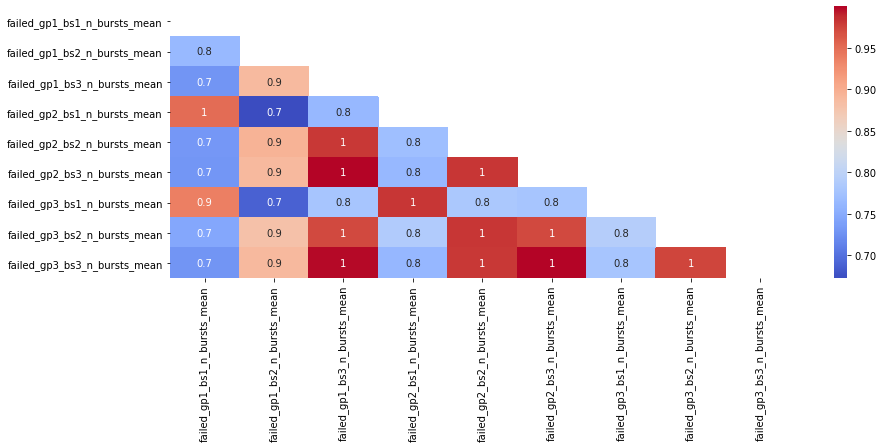

In [699]:
corr_matrix = failed_burst_metrics_df[[col for col in failed_burst_metrics_df.columns if col.endswith("n_bursts_mean")]].corr()
matrix = np.triu(corr_matrix)

#plt.figure()
sns.heatmap(corr_matrix,annot = True, cmap= 'coolwarm',fmt='.1g', mask=matrix)

In [700]:
for metric in [col for col in failed_burst_metrics_df.columns if col.endswith("n_bursts_mean")]:
    print(metric, stats.spearmanr(tags_comparison_with_metrics_x[metric], tags_comparison_with_metrics_y.post_release_bugs))

failed_gp1_bs1_n_bursts_mean SpearmanrResult(correlation=0.31452747892481725, pvalue=0.02773253146095242)
failed_gp1_bs2_n_bursts_mean SpearmanrResult(correlation=0.3089136670967627, pvalue=0.030795748123403195)
failed_gp1_bs3_n_bursts_mean SpearmanrResult(correlation=0.34502045395350545, pvalue=0.015188111886447685)
failed_gp2_bs1_n_bursts_mean SpearmanrResult(correlation=0.21628857279105806, pvalue=0.13552435851881828)
failed_gp2_bs2_n_bursts_mean SpearmanrResult(correlation=0.31937566997818284, pvalue=0.025295736629838278)
failed_gp2_bs3_n_bursts_mean SpearmanrResult(correlation=0.33577146141095093, pvalue=0.018341358718695758)
failed_gp3_bs1_n_bursts_mean SpearmanrResult(correlation=0.24252772216114302, pvalue=0.09314446962419635)
failed_gp3_bs2_n_bursts_mean SpearmanrResult(correlation=0.32039486401907064, pvalue=0.024806968556215083)
failed_gp3_bs3_n_bursts_mean SpearmanrResult(correlation=0.41658868566114216, pvalue=0.002906194122992339)


### Log parsing metrics

In [701]:
log_parsed_metrics = pd.read_csv(f"{csv_folder}/log_parsed_metrics_processed.csv", index_col=0)

In [702]:
log_parsed_metrics.head(3)

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,n_exceptions,n_error_classes,n_build_tools,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,year_month,errors_over_tests_total,failures_over_tests_total,skipped_over_tests_total
0,346751001,WEB_TESTS,['yarn'],False,3.0,2.0,1.0,2.0,1.0,1045.0,3294.0,[],[],1120.0,1117.0,0.0,3.0,[],['yarn'],0,0,1,False,False,False,False,False,True,False,346751001,346750998,2018-02-27 12:30:57+00:00,2018-02-27 12:30:21.579000+00:00,2018-02-27 12:34:24+00:00,37569.2,passed,2018-06-04 05:43:54.693000+00:00,7b245fbc45898ce11ab5cc0d60dc4f5621b94645,103144209,SONAR-10047 Use SearchSelect for tags in Bulk ...,refs/pull/3103/merge,https://github.com/SonarSource/sonarqube/pull/...,2018/02,0.002676,0.001784,0.000892
1,575471642,WEB_TESTS,"['yarn', 'jest', 'gradle']",False,3.0,2.0,1.0,9.0,1.0,1362.0,3919.0,[],[],2006.0,2005.0,0.0,1.0,[],"['yarn', 'jest', 'gradle']",0,0,3,False,True,False,True,False,True,False,575471642,575471639,2019-08-22 18:21:52+00:00,2019-08-22 18:21:19.464000+00:00,2019-08-22 18:33:18+00:00,39085.2,passed,2019-08-22 18:33:18.698000+00:00,7c2a234b30826c8f98dabff8506b1f49884b83a5,174121400,DOCS Add instructions for Application to a Por...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2019/08,0.001495,0.000997,0.000498
2,721125402,WEB_TESTS,"['yarn', 'gradle']",False,14.0,3.0,3.0,30.0,0.0,1426.0,4196.0,[],[],2412.0,2412.0,0.0,0.0,[],"['yarn', 'gradle']",0,0,2,False,True,False,False,False,True,False,721125402,721125400,2020-08-25 20:08:05+00:00,2020-08-25 20:06:58.581000+00:00,2020-08-25 20:18:58+00:00,39397.2,passed,2020-08-25 20:18:58.561000+00:00,60c64b2c9f95bb52d070758fa88a3881ae69b5e7,222268239,SONAR-13766 PostProjectAnalysisTask's 'descrip...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2020/08,0.005802,0.001243,0.000000


In [703]:
log_parsed_metrics.columns

Index(['job_id', 'build_target', 'build_tool',
       'build_canceled_open_pr_on_branch', 'errors', 'failures',
       'suspected_words', 'warnings', 'skipped_words', 'lines', 'words',
       'exceptions', 'error_classes', 'tests_total', 'tests_passed',
       'tests_failed', 'tests_skipped', 'failed_tasks', 'build_tool_str',
       'n_exceptions', 'n_error_classes', 'n_build_tools', 'maven_build',
       'gradle_build', 'mocha_build', 'jest_build', 'grunt_build',
       'yarn_build', 'node_build', 'id', 'buildid', 'started_at', 'created_at',
       'finished_at', 'number', 'state', 'updated_at', 'commitsha', 'commitid',
       'commitmessage', 'commitref', 'commitcompare_url', 'year_month',
       'errors_over_tests_total', 'failures_over_tests_total',
       'skipped_over_tests_total'],
      dtype='object')

In [704]:
### Mean
def calculate_aggregator_for_column(row, commitsDf, column, aggregator):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    _series = log_parsed_metrics[log_parsed_metrics.job_id.isin(_jobs.id.unique())][column]
    return getattr(_series, aggregator)()

def calculate_aggregator_for_column_per_commit_pr(row, column, aggregator):
    return calculate_aggregator_for_column(row, tags_iterative_pr_commits, column, aggregator)
def calculate_aggregator_for_column_per_commit_direct(row, column, aggregator):
    return calculate_aggregator_for_column(row, tags_comparison_commits, column, aggregator)
def calculate_aggregator_for_column_per_commit_fix(row, column, aggregator):
    return calculate_aggregator_for_column(row, tags_fix_commits, column, aggregator)
def calculate_aggregator_for_column_per_commit_pr_and_fix(row, column, aggregator):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_aggregator_for_column(row, _tmp, column, aggregator)

**Errors over tests**

In [705]:
tags_comparison.columns

Index(['from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date', 'to_commit_date',
       'diff_commit_dates', 'diff_commit_days', 'to_tag', 'from_tag',
       'percentage_passed_builds', 'percentage_canceled_builds',
       'percentage_failed_builds', 'percentage_errored_builds',
       'percentage_pr_builds', 'mean_passed_build_duration',
       'median_passed_build_duration', 'max_passed_build_duration',
       'min_passed_build_duration', 'mean_n_builds_per_pull_request',
       'median_n_builds_per_pull_request', 'max_n_builds_per_pull_request',
       'min_n_builds_per_pull_request', 'mean_n_builds_per_commitmessage',
       'median_n_builds_per_commitmessage', 'max_n_builds_per_commitmessage',
       'min_n_builds_per_commitmessage'],
      dtype='object')

In [706]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_errors_over_tests_total"] =\
    tags_comparison.apply(calculate_aggregator_for_column_per_commit_pr_and_fix,\
                          args=("errors_over_tests_total", agg), axis=1)

<AxesSubplot:xlabel='to_tag'>

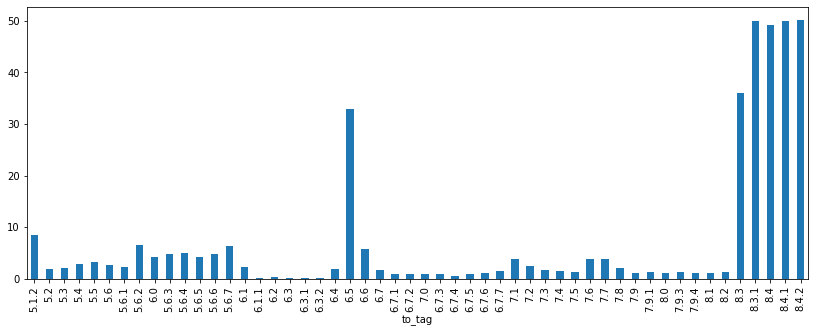

In [707]:
tags_comparison.set_index("to_tag")["mean_errors_over_tests_total"].plot(kind="bar")

**Failed tests**

In [708]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_failed_tests"] =\
    tags_comparison.apply(calculate_aggregator_for_column_per_commit_pr_and_fix,\
                          args=("tests_failed", agg), axis=1)

#tags_comparison.set_index("to_tag")["mean_failed_tests"].plot(kind="bar")

**Failures over total tests**

In [709]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_failures_over_tests_total"] =\
    tags_comparison.apply(calculate_aggregator_for_column_per_commit_pr_and_fix,\
                          args=("failures_over_tests_total", agg), axis=1)

#tags_comparison.set_index("to_tag")["mean_failures_over_tests_total"].plot(kind="bar")

**Skipped over tests**

In [710]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_skipped_over_tests_total"] =\
    tags_comparison.apply(calculate_aggregator_for_column_per_commit_pr_and_fix,\
                          args=("skipped_over_tests_total", agg), axis=1)

#tags_comparison.set_index("to_tag")["mean_skipped_over_tests_total"].plot(kind="bar")

**Number of exceptions**

In [711]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_n_exceptions"] =\
    tags_comparison.apply(calculate_aggregator_for_column_per_commit_pr_and_fix,\
                          args=("n_exceptions", agg), axis=1)

**Number of warnings**

In [712]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_n_warnings"] =\
    tags_comparison.apply(calculate_aggregator_for_column_per_commit_pr_and_fix,\
                          args=("warnings", agg), axis=1)

**Number of error classes**


In [713]:
for agg in ["mean", "median", "max", "min"]:
    tags_comparison[f"{agg}_n_error_classes"] =\
    tags_comparison.apply(calculate_aggregator_for_column_per_commit_pr_and_fix,\
                          args=("n_error_classes", agg), axis=1)

In [714]:
tags_comparison.columns

Index(['from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date', 'to_commit_date',
       'diff_commit_dates', 'diff_commit_days', 'to_tag', 'from_tag',
       'percentage_passed_builds', 'percentage_canceled_builds',
       'percentage_failed_builds', 'percentage_errored_builds',
       'percentage_pr_builds', 'mean_passed_build_duration',
       'median_passed_build_duration', 'max_passed_build_duration',
       'min_passed_build_duration', 'mean_n_builds_per_pull_request',
       'median_n_builds_per_pull_request', 'max_n_builds_per_pull_request',
       'min_n_builds_per_pull_request', 'mean_n_builds_per_commitmessage',
       'median_n_builds_per_commitmessage', 'max_n_builds_per_commitmessage',
       'min_n_builds_per_commitmessage', 'mean_errors_over_tests_total',
       'median_errors_over_tests_total', 'max_errors_over_tests_total',
       'min_errors_over

In [715]:
tags_comparison.drop(columns=['from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date', 'to_commit_date',
       'diff_commit_dates', 'diff_commit_days', 'to_tag', 'from_tag']).corrwith(sw_quality_metrics.post_release_bugs).min()

-0.2021849450415659

<AxesSubplot:ylabel='Frequency'>

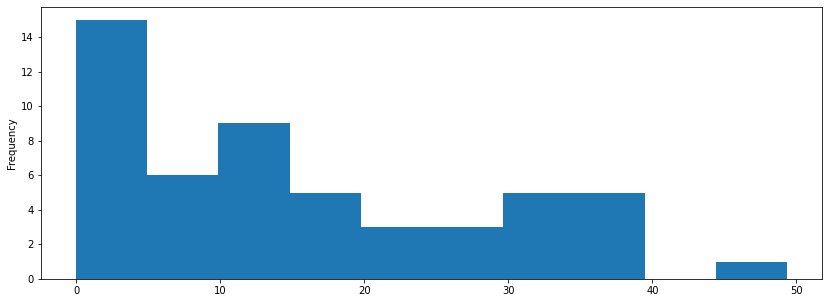

In [716]:
tags_comparison.mean_n_exceptions.plot(kind="hist")

<AxesSubplot:>

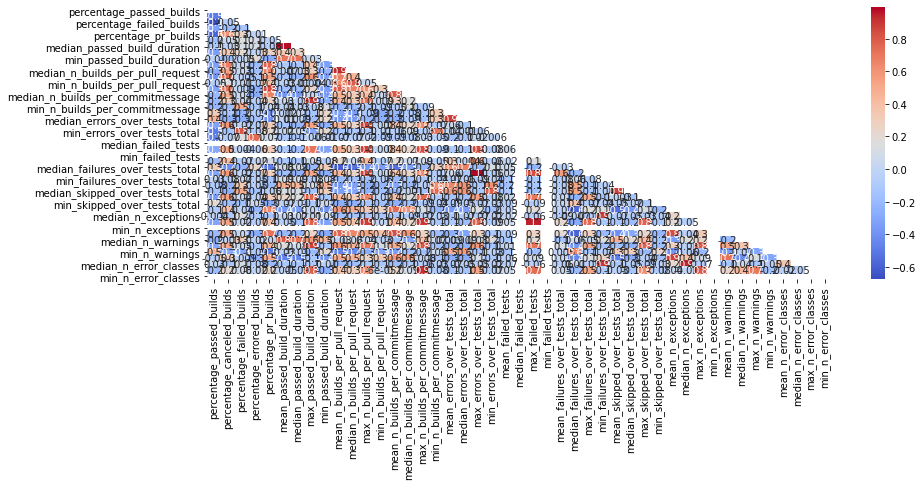

In [717]:
corr_matrix = tags_comparison.drop(columns=['from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date', 'to_commit_date',
       'diff_commit_dates', 'diff_commit_days', 'to_tag', 'from_tag']).corr()
matrix = np.triu(corr_matrix)

#plt.figure()
sns.heatmap(corr_matrix,annot = True, cmap= 'coolwarm',fmt='.1g', mask=matrix)
#plt.savefig(f"{figure_folder}/log-parsing-analysis/pearson-correlation.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
#plt.show()

**Merging metrics**

In [718]:
tags_comparison_with_metrics = tags_comparison.merge(failed_burst_metrics_df,left_index=True, right_index=True)
tags_comparison_with_metrics = tags_comparison_with_metrics.merge(not_passed_burst_metrics_df,left_index=True, right_index=True)
tags_comparison_with_metrics = tags_comparison_with_metrics.merge(canceled_burst_metrics_df,left_index=True, right_index=True)
tags_comparison_with_metrics.shape

(52, 276)

**Software quality metrics**

In [719]:
sw_quality_metrics= pd.read_csv(f"{csv_folder}/tags_software_quality_metrics_no_rc_and_milestones.csv", index_col=0)
sw_quality_metrics.head(2)

,version_name,post_release_bugs,pre_release_bugs,pre_release_after_tagging_bugs,dde,critical_post_release_bugs,minor_post_release_bugs,fix_time
0,4.5.7,1,0.0,0.0,0.000000,0.0,0.0,-434.28603
1,5.1,24,2.0,4.0,0.076923,0.0,2.0,-60.53169


In [720]:
sw_quality_metrics.columns

Index(['version_name', 'post_release_bugs', 'pre_release_bugs',
       'pre_release_after_tagging_bugs', 'dde', 'critical_post_release_bugs',
       'minor_post_release_bugs', 'fix_time'],
      dtype='object')

**Merging**

In [721]:
tags_comparison_with_metrics = tags_comparison_with_metrics.merge(sw_quality_metrics, left_on="to_tag", right_on="version_name")

**Extracting the dependent variables** 

In [722]:
tags_comparison_with_metrics_y=tags_comparison_with_metrics[["post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]]

In [723]:
tags_comparison_with_metrics_y.columns

Index(['post_release_bugs', 'fix_time', 'dde', 'critical_post_release_bugs',
       'minor_post_release_bugs'],
      dtype='object')

**Extracting the independent variables**

In [724]:
tags_comparison_with_metrics_x = tags_comparison_with_metrics.drop(columns=['from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag'])
tags_comparison_with_metrics_x = tags_comparison_with_metrics_x.drop(columns=['version_name','post_release_bugs', 'dde', 'critical_post_release_bugs',
       'minor_post_release_bugs', 'fix_time'])

In [725]:
tags_comparison_with_metrics_x.columns

Index(['percentage_passed_builds', 'percentage_canceled_builds',
       'percentage_failed_builds', 'percentage_errored_builds',
       'percentage_pr_builds', 'mean_passed_build_duration',
       'median_passed_build_duration', 'max_passed_build_duration',
       'min_passed_build_duration', 'mean_n_builds_per_pull_request',
       ...
       'canceled_gp3_bs3_n_bursts_mean', 'canceled_gp3_bs3_n_bursts_median',
       'canceled_gp3_bs3_n_bursts_max', 'canceled_gp3_bs3_n_bursts_min',
       'canceled_gp3_bs3_burst_size_mean',
       'canceled_gp3_bs3_burst_size_median', 'canceled_gp3_bs3_burst_size_max',
       'canceled_gp3_bs3_burst_size_min', 'pre_release_bugs',
       'pre_release_after_tagging_bugs'],
      dtype='object', length=263)

**Correlation**

In [726]:
corr_x = tags_comparison_with_metrics_x.corr()

In [727]:
corr_x.loc["canceled_gp3_bs3_n_bursts_mean"][corr_x.loc["canceled_gp3_bs3_n_bursts_mean"] > 0.8]

canceled_gp1_bs3_n_bursts_mean    0.811390
canceled_gp2_bs2_n_bursts_mean    0.812558
canceled_gp2_bs3_n_bursts_mean    0.903717
canceled_gp3_bs3_n_bursts_mean    1.000000
Name: canceled_gp3_bs3_n_bursts_mean, dtype: float64

In [728]:
from scipy import stats

**Check for normal distribution**

In [729]:
alpha = 0.05

In [730]:
k2, p_val = stats.normaltest(tags_comparison_with_metrics_x)

In [731]:
cols = tags_comparison_with_metrics_x.columns

In [732]:
cols[p_val > alpha]

Index(['mean_n_builds_per_pull_request', 'median_n_builds_per_commitmessage',
       'mean_n_exceptions', 'canceled_gp2_bs1_n_bursts_mean'],
      dtype='object')

### Spearman correlation with Number of post release bugs
https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide-2.php#:~:text=The%20Spearman%20correlation%20coefficient%2C%20rs%2C%20can%20take%20values%20from,the%20association%20between%20the%20ranks.

In [733]:
data = []
for col in tags_comparison_with_metrics_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_with_metrics_x[f"{col}"],tags_comparison_with_metrics_y.post_release_bugs)
    data.append((col, corr, p_val))
spearman_corr_post_release_bugs_df = pd.DataFrame(data, columns=["metric", "corr", "p_val"])

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [734]:
spearman_corr_post_release_bugs_df[spearman_corr_post_release_bugs_df.p_val< 0.05].sort_values(by="corr", ascending=False)

,metric,corr,p_val
261,pre_release_bugs,0.611658,0.000003
23,max_failed_tests,0.576088,0.000015
262,pre_release_after_tagging_bugs,0.572604,0.000017
255,canceled_gp3_bs3_n_bursts_max,0.552079,0.000039
21,mean_failed_tests,0.547622,0.000047
231,canceled_gp2_bs3_n_bursts_max,0.546425,0.000049
127,not_passed_gp1_bs2_n_bursts_max,0.542482,0.000057
207,canceled_gp1_bs3_n_bursts_max,0.539082,0.000064
211,canceled_gp1_bs3_burst_size_max,0.532730,0.000081
199,canceled_gp1_bs2_n_bursts_max,0.531687,0.000084


### Spearman correlation with Fix Time

In [737]:
data = []
for col in tags_comparison_with_metrics_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_with_metrics_x[f"{col}"],tags_comparison_with_metrics_y.fix_time)
    data.append((col, corr, p_val))
spearman_corr_fix_time_df = pd.DataFrame(data, columns=["metric", "corr", "p_val"])

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [738]:
spearman_corr_fix_time_df[spearman_corr_fix_time_df.p_val< 0.05].sort_values(by="corr", ascending=False)

,metric,corr,p_val
0,percentage_passed_builds,0.487431,0.000382
20,min_errors_over_tests_total,0.325004,0.022694
103,failed_gp3_bs2_n_bursts_max,-0.282909,0.048875
227,canceled_gp2_bs2_burst_size_max,-0.287389,0.045258
167,not_passed_gp3_bs1_n_bursts_max,-0.288771,0.044188
259,canceled_gp3_bs3_burst_size_max,-0.288992,0.044018
34,median_n_exceptions,-0.294085,0.040262
215,canceled_gp2_bs1_n_bursts_max,-0.298635,0.037132
231,canceled_gp2_bs3_n_bursts_max,-0.300299,0.036039
79,failed_gp2_bs2_n_bursts_max,-0.301936,0.034990


### Spearman correlation with DDE

In [ ]:
data = []
for col in tags_comparison_with_metrics_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_x[f"{col}"],tags_comparison_with_metrics_y.dde)
    data.append((col, corr, p_val))
spearman_corr_dde_df = pd.DataFrame(data, columns=["metric", "corr", "p_val"])

In [ ]:
spearman_corr_dde_df[spearman_corr_dde_df.p_val< 0.05].sort_values(by="corr", ascending=False)

In [ ]:
tags_comparison_with_metrics_x.isna().sum()